In [ ]:
import jax
import numpy as np
import tifffile
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from ctxseg.segmentation.flow import flow_to_mask
from ctxseg.segmentation.utils import remove_small_instances, clean_up_mask
from ctxseg.segmentation.metrics import LabelMetrics, MultiLabelMetrics
from ctxseg.utils.plotting import show_images

jnp = jax.numpy

import treescope
treescope.register_as_default()
treescope.basic_interactive_setup(autovisualize_arrays=True)

root = Path("dm_prediction_1step/")
dataset = 'cellpose'

## Evaluation

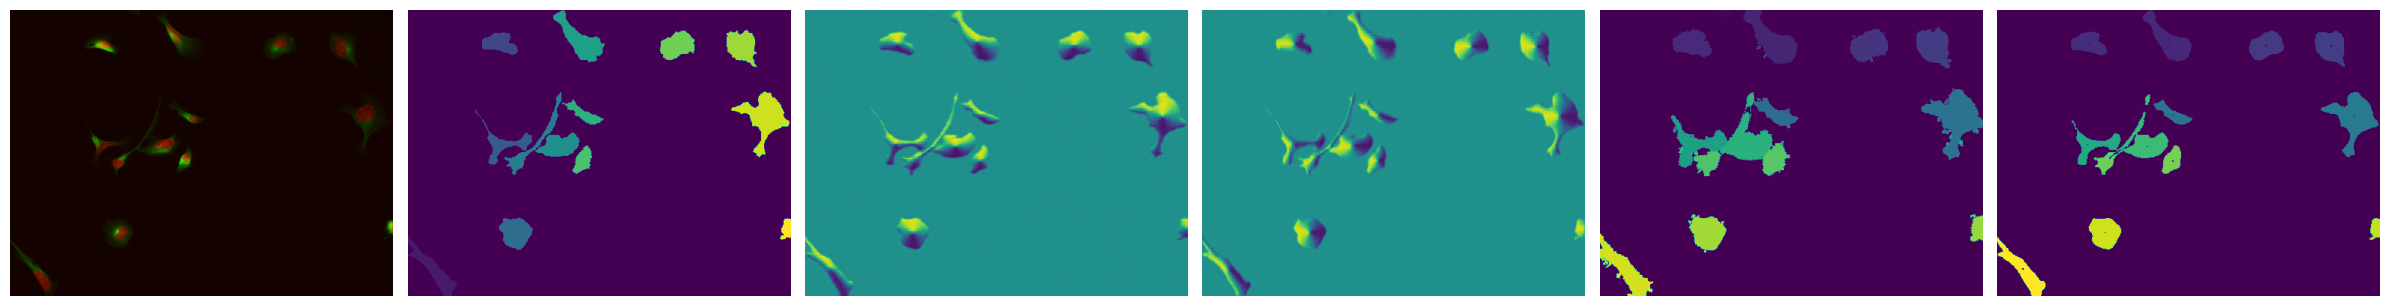

In [ ]:
# Visualize one example
img = tifffile.imread(root/dataset/"20.tif")
gt = tifffile.imread(root/dataset/"20_label.tif")
pred = tifffile.imread(root/dataset/"20_pred.tif")
label = flow_to_mask(np.moveaxis(pred, 0, -1))
show_images([img, gt, pred[0][0], pred[1][0], label[0]])

In [ ]:
# inference parameters
params = dict(
    niter=200,
    threshold=0.1,
    max_flow_err=0.,   
)

ids = [fn.name.split("_label")[0] for fn in (root/dataset).glob("*_label*")]

metric = LabelMetrics()
for img_n in tqdm(ids):
    img = tifffile.imread(root/dataset/f"{img_n}.tif")
    gt = tifffile.imread(root/dataset/f"{img_n}_label.tif")
    # gt = remove_small_instances(gt, 100) # hack correct test dataset error

    pred = tifffile.imread(root/dataset/f"{img_n}_pred.tif")
    pred = pred.squeeze() # only 1 prediction per image

    label = flow_to_mask(np.moveaxis(pred, 0, -1), **params)

    # optionally remove small cells
    label = clean_up_mask(remove_small_instances(label, 100))

    tifffile.imwrite(root/dataset/f"{img_n}_output.tif", label.astype("uint16"))

    metric.update(label, gt)

macro_results, micro_results = metric.compute(micros=True)
print("Macro metrics:")
print(macro_results)

df = pd.DataFrame.from_records(micro_results)
df['input'] = ids
df.dropna().sort_values('f1').head(20)

1324it [05:32,  3.98it/s]

{'n_preds': 120540, 'n_gts': 125805, 'n_tps': 108816, 'accuracy': 0.9027376804380288, 'recall': 0.8649576725885298, 'f1': 0.8836457904780883, 'instance_dice': 0.8589450324735456, 'ap': 0.7912222149510285}


## Baseline

In [ ]:
def grpc_call(server, image):
    import grpc
    import biopb.image as proto
    from biopb.image.utils import deserialize_to_numpy, serialize_from_numpy

    SERVER = server.split("//")[1]

    request = proto.ProcessRequest(
        image_data = proto.ImageData(pixels=serialize_from_numpy(image)),
    )
    options = [("grpc.max_receive_message_length", 1024 * 1024 * 512)]

    if server.startswith("https"):
        with grpc.secure_channel(
            target=SERVER,
            credentials=grpc.ssl_channel_credentials(),
            options=options,
        ) as channel:
            stub = proto.ProcessImageStub(channel)
            response = stub.Run(request)
    else:
        with grpc.insecure_channel(
            target=SERVER,
            options=options,
        ) as channel:
            stub = proto.ProcessImageStub(channel)
            response = stub.Run(request)

    # generate label
    label = deserialize_to_numpy(response.image_data.pixels)

    label = label[0, :, :, 0].astype(int)

    return label

In [ ]:
server = 'http://localhost:50051'

ids = [fn.name.split("_label")[0] for fn in (root/dataset).glob("*_label*")]

metric = LabelMetrics()
for img_n in tqdm(ids):
    img = tifffile.imread(root/dataset/f"{img_n}.tif")
    gt = tifffile.imread(root/dataset/f"{img_n}_label.tif")
    # gt = remove_small_instances(gt, 100)

    label = grpc_call(server, img)
    metric.update(label, gt)

macro_results, micro_results = metric.compute(micros=True)
print("Macro metrics:")
print(macro_results)

df = pd.DataFrame.from_records(micro_results)
df['input'] = ids
df.dropna().sort_values('f1').head(20)